<img align="center" src="figures/course.png" width="800">

#                                    16720 (B) Neural Networks for Recognition - Assignment 3

     Instructor: Kris Kitani                       TAs: Arka, Jinkun, Rawal, Rohan, Sheng-Yu

## Q2 Training Models (20 points)

Please download relevant data for this question by running the script, `./scripts/get_data.sh`. This will use `wget` and `unzip` to download 

http://www.cs.cmu.edu/~lkeselma/16720a_data/data.zip


http://www.cs.cmu.edu/~lkeselma/16720a_data/images.zip

and extract them to **data** and **image** folders


- Our input images are $32\times 32$ in size, please flatten them into one 1024 dimensional vector.
- We will multiply this vector by $\textbf{W}^{(1)}$, each row of $\textbf{W}^{(1)}$ can be seen as a weight image. 
- Reshaping each row into a $32\times 32$ image gives us an idea of what types of images each unit in the hidden layer has a high response to.

We have provided you three data **.mat** files to use for this section. The training data in **nist36\_train.mat** contains samples for each of the 26 upper-case letters of the alphabet and the 10 digits. This is the set you should use for training your network. The cross-validation set in **nist36\_valid.mat** contains samples from each class, and should be used in the training loop to see how the network is performing on data that it is not training on. This will help to spot over fitting. Finally, the test data in **nist36\_test.mat** contains testing data, and should be used for the final evaluation on your best model to see how well it will generalize to new unseen data.

### Q2.1 (8 points, write-up)
Train a network from scratch. Use a single hidden layer with 64 hidden units, and train for at least 30 epochs.

**Modify** the script to generate two plots: one showing the accuracy on both the training and validation set over the epochs, and the other showing the cross-entropy loss averaged over the data. The x-axis should represent the epoch number, while the y-axis represents the accuracy or loss. 

With these settings, you should see an accuracy on the validation set of at least 70\%.

Please submit to writeup, 1) iter vs loss, 2) iter vs acc as plot and the 3) final validation accuracy.

<font color="red">**Please include your answer to HW3:PDF**</font>

<font color="red">**For this question, please also submit screenshot of your code snippets to the write-up**</font>

In [2]:
import numpy as np
import pickle
import scipy.io
from ipynb.fs.defs.q1 import *
from matplotlib import pyplot as plt

In [3]:
import numpy as np
import pickle
import scipy.io
from ipynb.fs.defs.q1 import *
from matplotlib import pyplot as plt

train_data = scipy.io.loadmat('data/nist36_train.mat')
valid_data = scipy.io.loadmat('data/nist36_valid.mat')

train_x, train_y = train_data['train_data'], train_data['train_labels']
valid_x, valid_y = valid_data['valid_data'], valid_data['valid_labels']
i = 0

def network_forward(X, params):
    layer_1_out = forward(X, params, name = "layer1", activation = sigmoid)
    out         = forward(layer_1_out, params, name = "output", activation = softmax)
    return out

def network_backward(delta, params, lr):
    delta_2 = backwards(delta = delta,   params = params, name = "output", activation_deriv=linear_deriv)
    grad    = backwards(delta = delta_2, params = params, name = "layer1", activation_deriv=sigmoid_deriv)

    # Gradient descent
    params["Woutput"] = params["Woutput"] - lr * params["grad_Woutput"]
    params["Wlayer1"] = params["Wlayer1"] - lr * params["grad_Wlayer1"]
    params["boutput"] = params["boutput"] - lr * params["grad_boutput"]
    params["blayer1"] = params["blayer1"] - lr * params["grad_blayer1"]    


def train_network(train_x, train_y, comp_x, comp_y, comp_str, learning_rate, batch_size, hidden_size, max_iters, plot = True):
    # Batch Specifics
    batches = get_random_batches(train_x,train_y,batch_size)
    batch_num = len(batches)

    # Init the weights for the network
    params = {}
    initialize_weights(in_size = train_x.shape[1], out_size = hidden_size, params = params, name = "layer1" )
    initialize_weights(in_size = hidden_size, out_size = train_y.shape[1], params = params, name = "output")

    # with default settings, you should get loss < 150 and accuracy > 80%
    train_acc_arr  = []
    comp_acc_arr    = []
    train_loss_arr = []
    comp_loss_arr   = []
    comp_acc = None
    total_loss = 0
    total_acc = 0
    for itr in range(max_iters):
        total_loss = 0
        total_acc = 0
        for xb,yb in batches:
            # Forward Pass
            y_hat = network_forward(xb, params)

            # loss
            # be sure to add loss and accuracy to epoch totals
            loss_b, acc_b = compute_loss_and_acc(y = yb, probs = y_hat)
            total_loss += loss_b
            total_acc  += acc_b / len(batches)
            
            # backward and parameter update
            network_backward(y_hat - yb, params, learning_rate)
        if itr % 2 == 0:
            print("itr: {:02d} \t loss: {:.2f} \t acc : {:.2f}".format(itr,total_loss,total_acc))

        # Check on the Validation/Test Set
        comp_y_hat = network_forward(comp_x, params)
        comp_loss, comp_acc = compute_loss_and_acc(y = comp_y, probs = comp_y_hat)

        # Print Epoch Results
        # print(f"Epoch: {itr}")
        # print(f"Train Accuracy: {total_acc}")
        # print(f"Validation Accuracy: {valid_acc}")

        # Add Epoch Results to the array
        train_acc_arr.append(total_acc)
        train_loss_arr.append(total_loss / train_x.shape[0])
        comp_acc_arr.append(comp_acc)
        comp_loss_arr.append(comp_loss / valid_x.shape[0])

    # Print final validation acc and plot the results
    print('Validation accuracy: ', comp_acc)

    # Accuracy
    if plot:
        epochs = list(range(max_iters))
        global i
        plt.figure(i)
        plt.title("Accuracy vs. Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.plot(epochs, train_acc_arr, "rx-", label = "Training Accuracy")
        plt.plot(epochs, comp_acc_arr, "go--", label = f"{comp_str} Accuracy")
        plt.legend()

        # Loss
        i+=1
        plt.figure(i)
        plt.title("Average Loss per Sample vs. Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Average Loss")
        plt.plot(epochs, train_loss_arr, "rx-", label = "Training Loss")
        plt.plot(epochs, comp_loss_arr, "go--", label = f"{comp_str} Loss")
        plt.legend()
        i+=1

    return params, total_loss, total_acc


itr: 00 	 loss: 35465.01 	 acc : 0.12
itr: 02 	 loss: 22845.31 	 acc : 0.43
itr: 04 	 loss: 17245.65 	 acc : 0.56
itr: 06 	 loss: 14621.85 	 acc : 0.61
itr: 08 	 loss: 12712.02 	 acc : 0.66
itr: 10 	 loss: 11228.31 	 acc : 0.71
itr: 12 	 loss: 10290.62 	 acc : 0.73
itr: 14 	 loss: 9601.42 	 acc : 0.75
itr: 16 	 loss: 9015.02 	 acc : 0.77
itr: 18 	 loss: 8473.74 	 acc : 0.78
itr: 20 	 loss: 8010.08 	 acc : 0.79
itr: 22 	 loss: 7603.49 	 acc : 0.80
itr: 24 	 loss: 7200.33 	 acc : 0.81
itr: 26 	 loss: 6833.69 	 acc : 0.82
itr: 28 	 loss: 6491.52 	 acc : 0.83
itr: 30 	 loss: 6183.89 	 acc : 0.84
itr: 32 	 loss: 5910.10 	 acc : 0.85
itr: 34 	 loss: 5660.71 	 acc : 0.86
itr: 36 	 loss: 5427.60 	 acc : 0.86
itr: 38 	 loss: 5203.72 	 acc : 0.87
itr: 40 	 loss: 4988.85 	 acc : 0.88
itr: 42 	 loss: 4785.87 	 acc : 0.88
itr: 44 	 loss: 4597.00 	 acc : 0.89
itr: 46 	 loss: 4421.61 	 acc : 0.89
itr: 48 	 loss: 4256.21 	 acc : 0.90
itr: 50 	 loss: 4097.28 	 acc : 0.90
itr: 52 	 loss: 3944.86 	 acc :

({'Wlayer1': array([[ 0.08189081,  0.20701551, -0.13563634, ...,  0.02403443,
           0.02965047,  0.05119232],
         [ 0.09572725,  0.19126944, -0.15378686, ...,  0.09591879,
           0.03557369, -0.05681787],
         [ 0.05105762,  0.14135274, -0.05927454, ...,  0.13376143,
          -0.06814824, -0.03789205],
         ...,
         [ 0.10024338,  0.17798445, -0.16470737, ...,  0.04630427,
           0.00928961, -0.05031649],
         [ 0.07597509,  0.18915325, -0.15167411, ...,  0.00714359,
           0.03107793, -0.06077466],
         [ 0.12521948,  0.13184849, -0.17032301, ...,  0.1395148 ,
           0.05473837,  0.01411616]]),
  'blayer1': array([ 1.47650526e-03,  1.64602831e-03, -1.75373490e-03,  1.90623992e-03,
          7.19485952e-04,  2.50494553e-04, -9.51687178e-04,  2.27858544e-03,
         -2.45593067e-03, -1.29822900e-03,  1.49340652e-03,  1.77899857e-03,
          8.14832193e-04, -7.32580817e-04,  6.16414540e-04, -1.89013313e-03,
          8.21466431e-04,  8.4

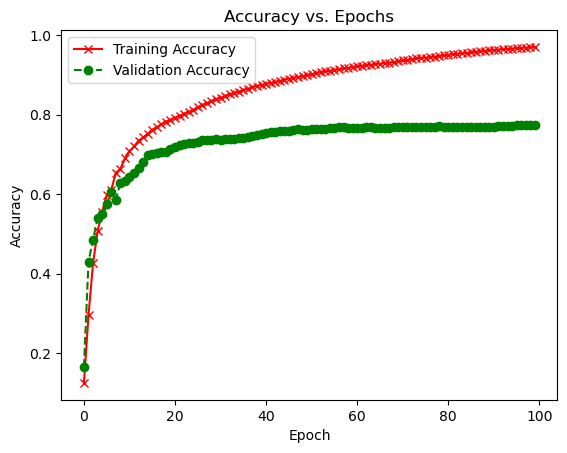

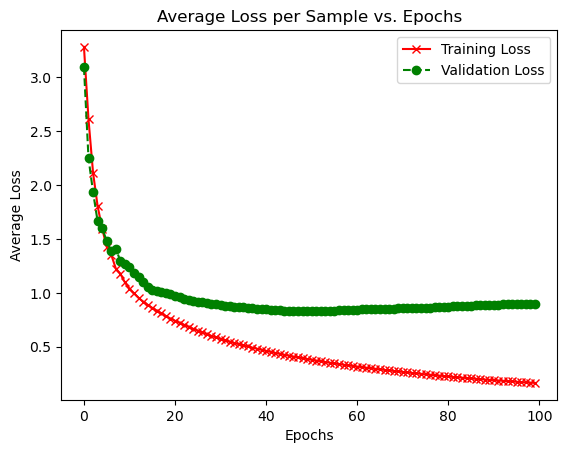

In [4]:
max_iters = 100
# pick a batch size, learning rate
batch_size    = 100
learning_rate = .005
hidden_size = 64

train_network(train_x, train_y, valid_x, valid_y, "Validation", learning_rate, batch_size, hidden_size, max_iters)

### Q2.2 (3 points, write-up)
Use your modified training script to train three networks, one with your best learning rate, one with 10 times that learning rate and one with one tenth that learning rate. Include all 6 plots in your writeup. Comment on how the learning rates affect the training, and report the final accuracy of the best network on the test set.

<font color="red">**Please include your answer to HW3:PDF**</font>

LR: 0.0001
itr: 00 	 loss: 39538.22 	 acc : 0.03
itr: 02 	 loss: 38390.71 	 acc : 0.05
itr: 04 	 loss: 37961.03 	 acc : 0.10
itr: 06 	 loss: 37497.66 	 acc : 0.15
itr: 08 	 loss: 36997.76 	 acc : 0.20
itr: 10 	 loss: 36465.79 	 acc : 0.25
itr: 12 	 loss: 35903.25 	 acc : 0.29
itr: 14 	 loss: 35313.60 	 acc : 0.32
itr: 16 	 loss: 34702.86 	 acc : 0.34
itr: 18 	 loss: 34079.03 	 acc : 0.36
itr: 20 	 loss: 33447.23 	 acc : 0.38
itr: 22 	 loss: 32811.74 	 acc : 0.39
itr: 24 	 loss: 32177.33 	 acc : 0.41
itr: 26 	 loss: 31546.02 	 acc : 0.42
itr: 28 	 loss: 30919.15 	 acc : 0.43
itr: 30 	 loss: 30303.50 	 acc : 0.44
itr: 32 	 loss: 29702.00 	 acc : 0.45
itr: 34 	 loss: 29115.58 	 acc : 0.46
itr: 36 	 loss: 28544.59 	 acc : 0.47
itr: 38 	 loss: 27989.20 	 acc : 0.48
itr: 40 	 loss: 27449.47 	 acc : 0.49
itr: 42 	 loss: 26925.27 	 acc : 0.50
itr: 44 	 loss: 26416.42 	 acc : 0.51
itr: 46 	 loss: 25922.94 	 acc : 0.51
itr: 48 	 loss: 25445.03 	 acc : 0.52
itr: 50 	 loss: 24982.74 	 acc : 0.53
i

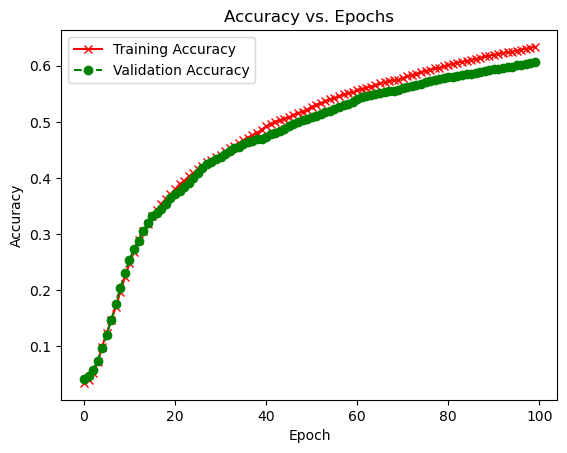

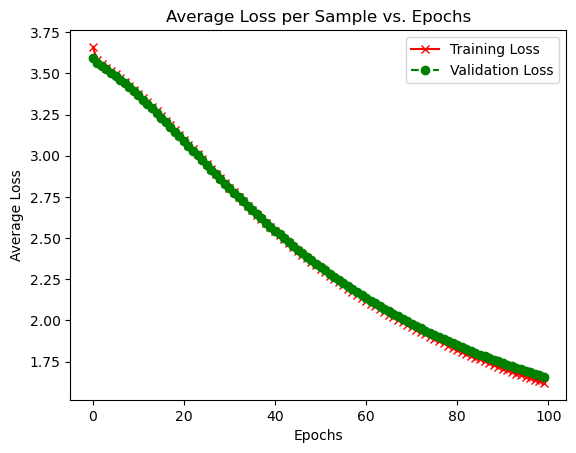

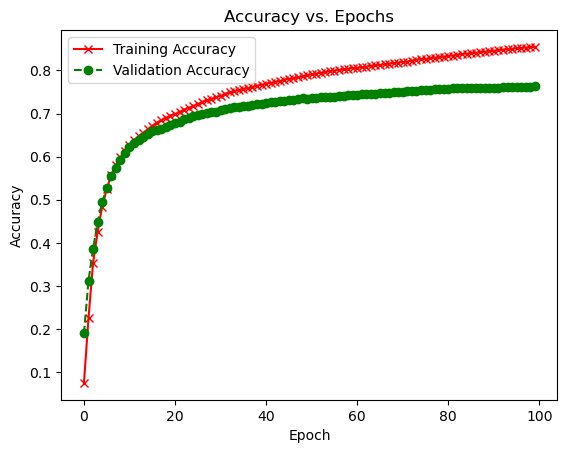

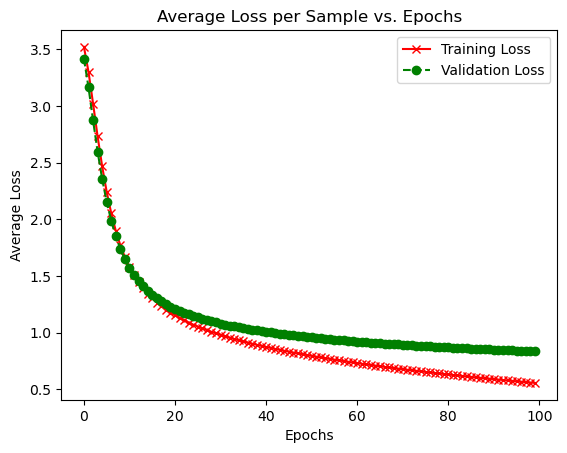

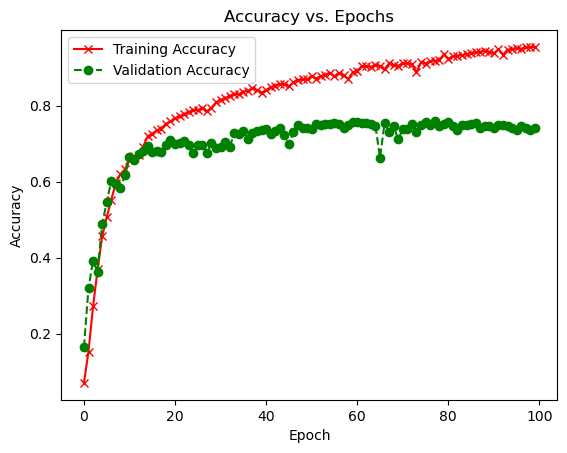

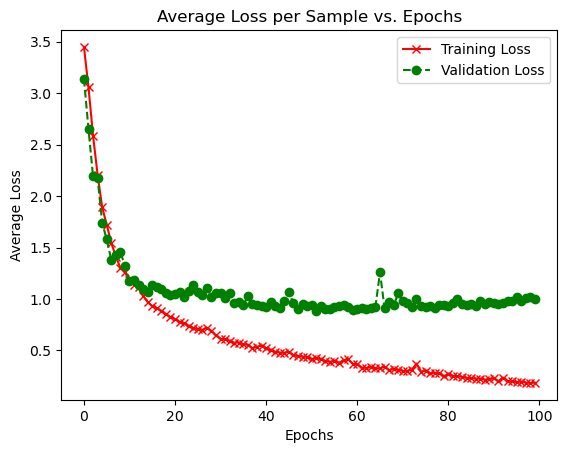

In [5]:
# Grab the test set
test_data = scipy.io.loadmat('data/nist36_test.mat')
test_x, test_y = test_data["test_data"], test_data["test_labels"]

max_iters = 100
# pick a batch size, learning rate
batch_size = 100
hidden_size = 64

def eval_test_set(test_x, test_y, params):
    y_hat_test = network_forward(test_x, params)
    test_loss, test_acc = compute_loss_and_acc(test_y, y_hat_test)
    print(f"Average Test Loss: {test_loss/test_x.shape[0]}")
    print(f"Test Accuracy: {test_acc}")
    return test_loss, test_acc

# def plot_lr_results(lrs, train_losses, train_accs, test_losses, test_accs):
#     global i
#     plt.figure(i)
#     plt.plot(lrs, train_losses, "rx-", label="Training Losses")
#     plt.plot(lrs, test_losses, "go-", label = "Test Losses")
#     i += 1
#     plt.figure(i)
#     plt.plot(lrs, train)

# Conduct the test
best_lr = 1e-3
lrs = [best_lr/10, best_lr, best_lr * 10]

test_losses  = []
train_losses = []
test_accs    = []
train_accs    = []
for lr_i in lrs:
    print(f"LR: {lr_i}")
    params, train_loss, train_acc = train_network(train_x, train_y, valid_x, valid_y, "Validation", lr_i, batch_size, hidden_size, max_iters, plot = True)
    test_loss, test_acc = eval_test_set(test_x, test_y, params)

    print(f"Test Accuracy: {test_acc}")


### Q2.3 (2 points, write-up)
Visualize the first layer weights that your network learned. Compare these to the network weights immediately after initialization. Include both visualizations in your writeup. Comment on the learned weights. Do you notice any patterns?

<font color="red">**Please include your answer to HW3:PDF**</font>

Validation accuracy:  None
itr: 00 	 loss: 38029.05 	 acc : 0.08
itr: 02 	 loss: 32617.49 	 acc : 0.34
itr: 04 	 loss: 26803.61 	 acc : 0.47
itr: 06 	 loss: 22421.24 	 acc : 0.55
itr: 08 	 loss: 19382.46 	 acc : 0.59
itr: 10 	 loss: 17266.39 	 acc : 0.62
itr: 12 	 loss: 15755.94 	 acc : 0.64
itr: 14 	 loss: 14639.11 	 acc : 0.66
itr: 16 	 loss: 13780.61 	 acc : 0.67
itr: 18 	 loss: 13095.85 	 acc : 0.68
itr: 20 	 loss: 12531.66 	 acc : 0.69
itr: 22 	 loss: 12054.00 	 acc : 0.70
itr: 24 	 loss: 11640.47 	 acc : 0.71
itr: 26 	 loss: 11275.91 	 acc : 0.72
itr: 28 	 loss: 10949.76 	 acc : 0.73
itr: 30 	 loss: 10654.44 	 acc : 0.74
itr: 32 	 loss: 10384.38 	 acc : 0.75
itr: 34 	 loss: 10135.38 	 acc : 0.75
itr: 36 	 loss: 9904.20 	 acc : 0.76
itr: 38 	 loss: 9688.30 	 acc : 0.76
itr: 40 	 loss: 9485.66 	 acc : 0.77
itr: 42 	 loss: 9294.62 	 acc : 0.77
itr: 44 	 loss: 9113.83 	 acc : 0.78
itr: 46 	 loss: 8942.16 	 acc : 0.78
itr: 48 	 loss: 8778.65 	 acc : 0.78
itr: 50 	 loss: 8622.49 	 acc 

TypeError: Invalid shape (1024,) for image data

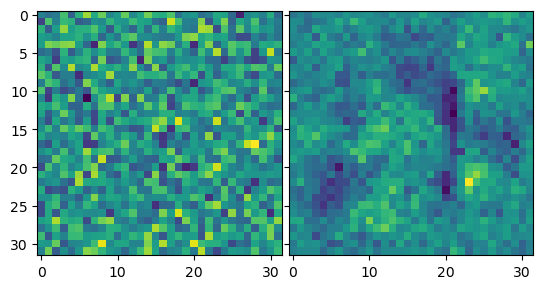

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

init_params, _, _   = train_network(train_x, train_y, valid_x, valid_y, "Validation", .001, batch_size=100, hidden_size=64, max_iters=0, plot= False)
trained_params,_,_ = train_network(train_x, train_y, valid_x, valid_y, "Validation", .001, batch_size=100, hidden_size=64, max_iters=100, plot= False)

init_weights = init_params["Wlayer1"]
print(init_weights.shape)
trained_weights = trained_params["Wlayer1"]


fig = plt.figure(1)
grid1 = ImageGrid(fig, 111,
                nrows_ncols = (1,2),
                axes_pad = 0.07)

print("Initial Weights")
init_vis = np.mean(init_weights, axis = 1).reshape(32,32)
grid1[0].imshow(init_vis)
trained_vis = np.mean(trained_weights, axis = 1).reshape(32, 32)
grid1[1].imshow(trained_vis)

# for col in range(init_weights.shape[1]):
#     print(col)
#     grid1[col].imshow(init_weights[:, col].reshape(32, 32))




### Q2.4 (3 points, write-up)
To visualize the deeper second layer we use the following method:

Given $y_1$ (size 64) as the output of the first layer and $y_2$ (size 36) as the output of the second layer. We will take a [one-hot encoding](https://en.wikipedia.org/wiki/One-hot) for any number $i$ in range $[0, 36)$ and multiply it with the transposed weight matrix of layer 2, $W_2^T$. Similarly multiply the output with $W_1^T$ to get back an array of the size of the input image (1024). Reshape and visualize the result.

For these values of $i$, additionally include the image in the validation set for which $y_2(i)$ attains it's maximum value.

<font color="red">**Please include your answer to HW3:PDF**</font>

itr: 00 	 loss: 37996.61 	 acc : 0.08
itr: 02 	 loss: 32474.02 	 acc : 0.34
itr: 04 	 loss: 26903.09 	 acc : 0.48
itr: 06 	 loss: 22643.87 	 acc : 0.55
itr: 08 	 loss: 19619.27 	 acc : 0.60
itr: 10 	 loss: 17498.26 	 acc : 0.62
itr: 12 	 loss: 15979.54 	 acc : 0.64
itr: 14 	 loss: 14849.11 	 acc : 0.66
itr: 16 	 loss: 13973.11 	 acc : 0.67
itr: 18 	 loss: 13270.68 	 acc : 0.69
itr: 20 	 loss: 12690.06 	 acc : 0.70
itr: 22 	 loss: 12198.20 	 acc : 0.71
itr: 24 	 loss: 11772.84 	 acc : 0.72
itr: 26 	 loss: 11398.49 	 acc : 0.72
itr: 28 	 loss: 11064.15 	 acc : 0.73
itr: 30 	 loss: 10761.94 	 acc : 0.74
itr: 32 	 loss: 10486.05 	 acc : 0.75
itr: 34 	 loss: 10232.12 	 acc : 0.75
itr: 36 	 loss: 9996.77 	 acc : 0.76
itr: 38 	 loss: 9777.33 	 acc : 0.77
itr: 40 	 loss: 9571.65 	 acc : 0.77
itr: 42 	 loss: 9377.97 	 acc : 0.78
itr: 44 	 loss: 9194.86 	 acc : 0.78
itr: 46 	 loss: 9021.11 	 acc : 0.78
itr: 48 	 loss: 8855.73 	 acc : 0.79
itr: 50 	 loss: 8697.85 	 acc : 0.79
itr: 52 	 loss: 8546

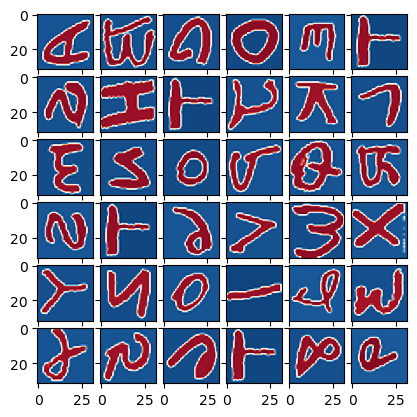

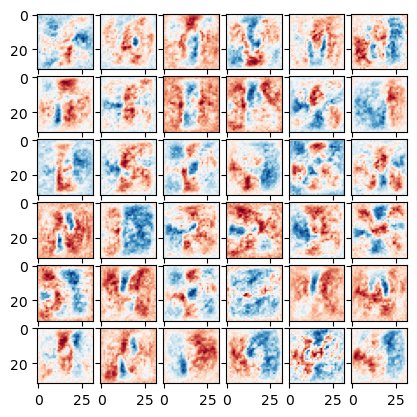

In [ ]:
# Please put your code for Q3.4 here
trained_params,_,_ = train_network(train_x, train_y, valid_x, valid_y, "Validation", .001, batch_size=100, hidden_size=64, max_iters=100, plot= False)

trained_weights_layer1 = trained_params["Wlayer1"]
trained_weights_layer2 = trained_params["Woutput"]

val_imgs = np.stack([img.flatten() for img in valid_x])
responses = (val_imgs @ trained_weights_layer1) @ trained_weights_layer2
# The highest response for each number [0, 35]
highest_responses = np.argmax(responses, axis = 0)

# Image Grid for the best image
fig1 = plt.figure(1)
grid1 = ImageGrid(fig1, 111,
                nrows_ncols = (6,6),
                axes_pad = 0.07)

# Image grid for the inverted images
fig2 = plt.figure(2)
grid2 = ImageGrid(fig2, 111,
                nrows_ncols = (6,6),
                axes_pad = 0.07)

one_hots = np.eye(36)
for i in range(36):
    print(i)
    one_hot = one_hots[i]

    # Pick out the best validation image and show it
    best_val_img = valid_x[highest_responses[i]]
    grid1[i].imshow(best_val_img.reshape(32, 32), cmap=plt.cm.RdBu)

    # Show the response using the weights
    out_1 = one_hot @ trained_weights_layer2.T
    out_2 = out_1 @ trained_weights_layer1.T
    response = out_2.reshape(32, 32)
    grid2[i].imshow(response, cmap=plt.cm.RdBu)

    



### Q2.5 (4 points, write-up)
Visualize the confusion matrix for your best model for the test set. Comment on the top few pairs of classes that are most commonly confused.

<font color="red">**Please include your answer to HW3:PDF**</font>

itr: 00 	 loss: 37962.81 	 acc : 0.08
itr: 02 	 loss: 32229.74 	 acc : 0.36
itr: 04 	 loss: 26427.64 	 acc : 0.50
itr: 06 	 loss: 22159.16 	 acc : 0.56
itr: 08 	 loss: 19184.69 	 acc : 0.60
itr: 10 	 loss: 17137.92 	 acc : 0.63
itr: 12 	 loss: 15675.80 	 acc : 0.65
itr: 14 	 loss: 14587.21 	 acc : 0.66
itr: 16 	 loss: 13744.04 	 acc : 0.68
itr: 18 	 loss: 13067.44 	 acc : 0.69
itr: 20 	 loss: 12507.78 	 acc : 0.70
itr: 22 	 loss: 12032.92 	 acc : 0.71
itr: 24 	 loss: 11621.44 	 acc : 0.72
itr: 26 	 loss: 11258.66 	 acc : 0.73
itr: 28 	 loss: 10934.20 	 acc : 0.73
itr: 30 	 loss: 10640.55 	 acc : 0.74
itr: 32 	 loss: 10372.12 	 acc : 0.75
itr: 34 	 loss: 10124.66 	 acc : 0.75
itr: 36 	 loss: 9894.91 	 acc : 0.76
itr: 38 	 loss: 9680.28 	 acc : 0.76
itr: 40 	 loss: 9478.71 	 acc : 0.77
itr: 42 	 loss: 9288.55 	 acc : 0.77
itr: 44 	 loss: 9108.43 	 acc : 0.78
itr: 46 	 loss: 8937.24 	 acc : 0.78
itr: 48 	 loss: 8774.01 	 acc : 0.78
itr: 50 	 loss: 8617.96 	 acc : 0.79
itr: 52 	 loss: 8468

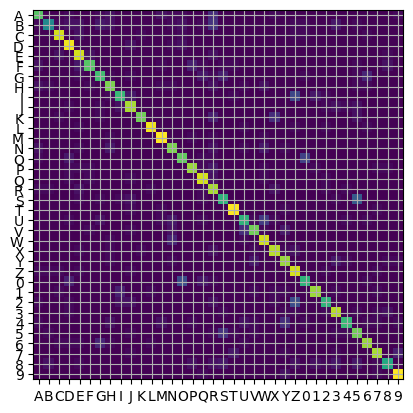

In [12]:
import matplotlib.pyplot as plt

confusion_matrix = np.zeros((train_y.shape[1],train_y.shape[1]))

# Best paramters
max_iters = 100
batch_size = 100
hidden_size = 64
best_lr = 1e-3

# plt.figure(5)
# plt.imshow(train_x[0].reshape(32, 32))
train_params, _, _ = train_network(train_x, train_y, valid_x, valid_y, "Validation", best_lr, batch_size, hidden_size, max_iters, plot = False)
y_hat = network_forward(test_x, params)



# Save the params to a pickle file
with open('q2_weights.pickle','wb') as f:
    pickle.dump(train_params, f, protocol=pickle.HIGHEST_PROTOCOL)

for i in range(len(y_hat)):
    y_hat_label = int(np.argmax(y_hat[i]))
    y_label     = int(np.argmax(test_y[i]))
    confusion_matrix[y_label, y_hat_label] += 1

plt.figure(1)
plt.imshow(confusion_matrix,interpolation='nearest')
plt.grid(True)
plt.xticks(np.arange(36),string.ascii_uppercase[:26] + ''.join([str(_) for _ in range(10)]))
plt.yticks(np.arange(36),string.ascii_uppercase[:26] + ''.join([str(_) for _ in range(10)]))
plt.show()